# SOIL FERTILITY CLASSIFICATION USING KNN MODEL

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Set random seed for reproducibility
np.random.seed(42)

## 2. Load or Generate Soil Fertility Dataset

We'll generate a synthetic dataset for soil fertility classification. In a real-world scenario, you would load your actual data here.

In [22]:
def generate_synthetic_data(n_samples=500):
    # Generate synthetic data that mimics soil fertility parameters
    np.random.seed(42)
    
    # Generate soil parameters (features)
    nitrogen = np.random.normal(loc=150, scale=50, size=n_samples)  # ppm
    phosphorus = np.random.normal(loc=30, scale=15, size=n_samples)  # ppm
    potassium = np.random.normal(loc=200, scale=60, size=n_samples)  # ppm
    ph = np.random.normal(loc=6.5, scale=1.0, size=n_samples)  # pH scale
    organic_matter = np.random.normal(loc=3.5, scale=1.5, size=n_samples)  # %
    moisture = np.random.normal(loc=25, scale=8, size=n_samples)  # %
    
    # Create features DataFrame
    data = pd.DataFrame({
        'Nitrogen': nitrogen,
        'Phosphorus': phosphorus,
        'Potassium': potassium,
        'pH': ph,
        'OrganicMatter': organic_matter,
        'Moisture': moisture
    })
    
    # Define fertility class based on synthetic rules
    # Set logical thresholds for different soil fertility classes
    fertility_class = []
    
    for i in range(n_samples):
        n, p, k = nitrogen[i], phosphorus[i], potassium[i]
        ph_val = ph[i]
        om = organic_matter[i]
        
        if (n > 180 and p > 40 and k > 240 and om > 4.0 and 6.0 < ph_val < 7.5):
            fertility_class.append('High')
        elif (n < 100 or p < 15 or k < 150 or om < 2.0 or ph_val < 5.0 or ph_val > 8.0):
            fertility_class.append('Low')
        else:
            fertility_class.append('Medium')
    
    data['FertilityClass'] = fertility_class
    
    return data

# Try to load data from a CSV file if it exists, otherwise generate synthetic data
try:
    print("Attempting to load soil fertility data from CSV...")
    soil_data = pd.read_csv('soil_fertility_data.csv')
    print("Data loaded successfully!")
except FileNotFoundError:
    print("No data file found. Generating synthetic data...")
    soil_data = generate_synthetic_data(500)
    print("Synthetic data generated!")

# Display the first few rows of the dataset
soil_data.head()

Attempting to load soil fertility data from CSV...
No data file found. Generating synthetic data...
Synthetic data generated!


,Nitrogen,Phosphorus,Potassium,pH,OrganicMatter,Moisture,FertilityClass
0,174.835708,43.892663,283.961326,7.278361,2.487233,29.564904,Medium
1,143.086785,58.641250,255.478021,5.948814,3.283222,32.745477,Medium
2,182.384427,9.021486,203.577822,5.681801,2.311370,22.349533,Low
3,226.151493,38.444539,161.183793,6.496626,3.038058,20.102106,Medium
4,138.292331,20.240361,241.893399,6.329815,0.659578,16.318796,Low


## 3. Exploratory Data Analysis (EDA)

In [23]:
# Check basic information about the dataset
print("Dataset shape:", soil_data.shape)
print("\nBasic statistics:")
soil_data.describe()

Dataset shape: (500, 7)

Basic statistics:


,Nitrogen,Phosphorus,Potassium,pH,OrganicMatter,Moisture
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,150.341900,30.477392,206.509072,6.533188,3.482725,25.185478
std,49.062662,14.669958,60.614781,0.984066,1.439349,8.059508
min,-12.063367,-10.453300,26.224677,3.559611,-1.029268,1.070912
25%,114.984630,21.070624,163.854223,5.888064,2.508895,19.982781
50%,150.639857,30.427974,207.188351,6.491087,3.495272,25.028285
75%,181.839163,39.768634,245.284302,7.199769,4.503765,30.058137
max,342.636575,69.485731,356.100987,9.693108,8.164878,56.409902



Distribution of Fertility Classes:
FertilityClass
Low       273
Medium    226
High        1
Name: count, dtype: int64


/tmp/ipykernel_55143/268120459.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


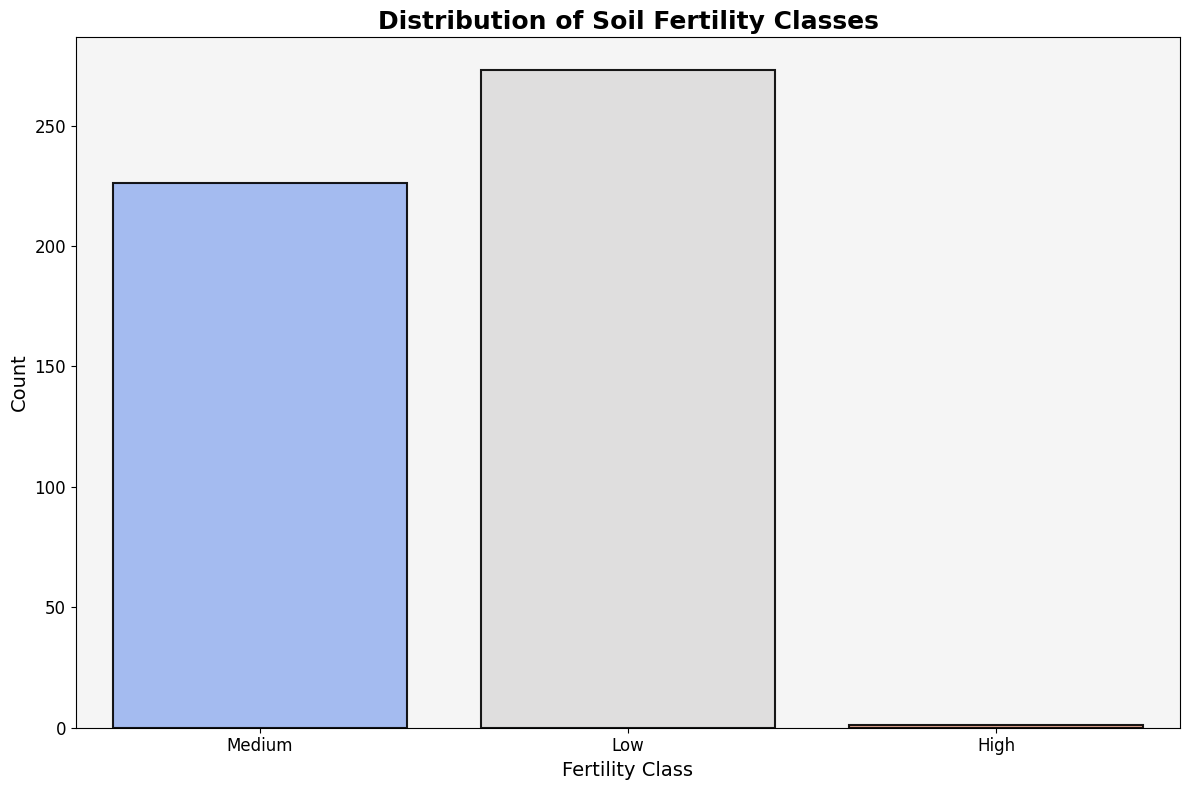

In [24]:
# Analyze the distribution of Fertility Classes
class_dist = soil_data['FertilityClass'].value_counts()
print("\nDistribution of Fertility Classes:")
print(class_dist)

# Visualize the distribution with modern design elements
plt.figure(figsize=(12, 8))

sns.countplot(
    x='FertilityClass', 
    data=soil_data, 
    palette='coolwarm',    # Modern and visually appealing palette
    edgecolor='black',     # Defines sharp edges for visual clarity
    linewidth=1.5,         # Enhances edge visibility
    alpha=0.9              # Adjusts transparency for better aesthetics
)

# Add a gradient background for visual enhancement
plt.gca().set_facecolor('#f5f5f5')

# Improve the layout and readability of the plot
plt.title("Distribution of Soil Fertility Classes", fontsize=18, fontweight='bold')
plt.ylabel("Count", fontsize=14)
plt.xlabel("Fertility Class", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust layout for neat presentation
plt.tight_layout()

# Display the plot
plt.show()

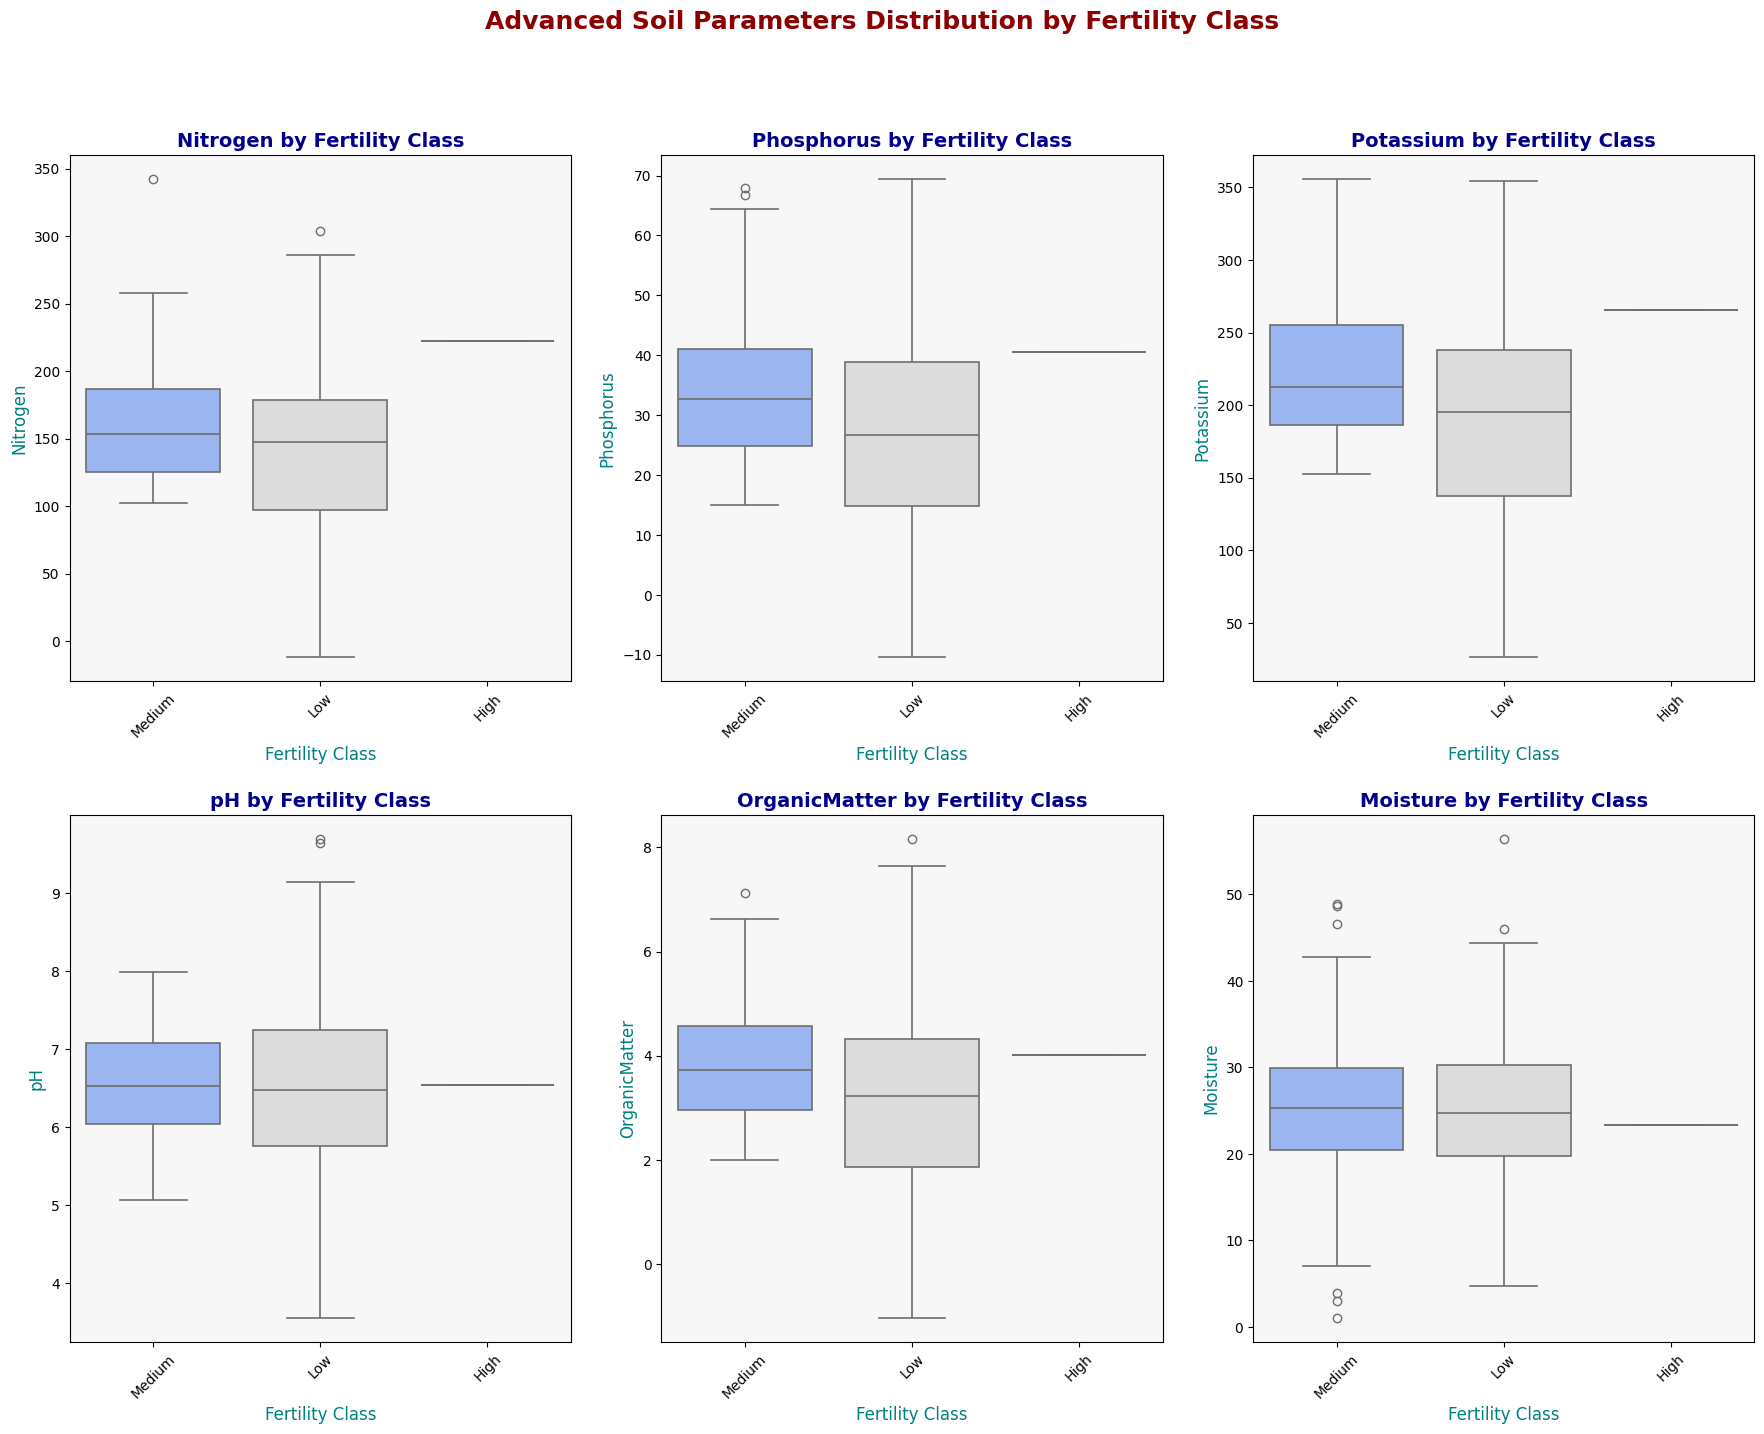

In [25]:
# Advanced Visualization: Soil Parameters vs Fertility Class
plt.figure(figsize=(18, 14))  # Increased size for better visibility

features = ['Nitrogen', 'Phosphorus', 'Potassium', 'pH', 'OrganicMatter', 'Moisture']

for i, feature in enumerate(features, 1):
    ax = plt.subplot(2, 3, i)  # Use `ax` for customizations
    sns.boxplot(
        x='FertilityClass', 
        y=feature, 
        data=soil_data, 
        hue='FertilityClass', 
        palette='coolwarm',   # Switched to a more modern palette
        linewidth=1.2,        # Added a sharper visual edge
        dodge=False           # Avoid unnecessary shifts
    )

    # Customize title and axis labels
    ax.set_title(f"{feature} by Fertility Class", fontsize=14, fontweight='bold', color='darkblue')
    ax.set_xlabel("Fertility Class", fontsize=12, color='teal')
    ax.set_ylabel(feature, fontsize=12, color='teal')

    # Enhance plot background for clarity
    ax.set_facecolor('#f7f7f7')  # Light gray background to focus on the data

    # Rotate x-tick labels for readability if needed
    ax.tick_params(axis='x', rotation=45, labelsize=10)

# Add a main title
plt.suptitle(
    "Advanced Soil Parameters Distribution by Fertility Class",
    fontsize=18, fontweight='bold', color='darkred', y=1.03
)

plt.tight_layout(pad=2.0)  # Adjust padding for a clean look
plt.show()

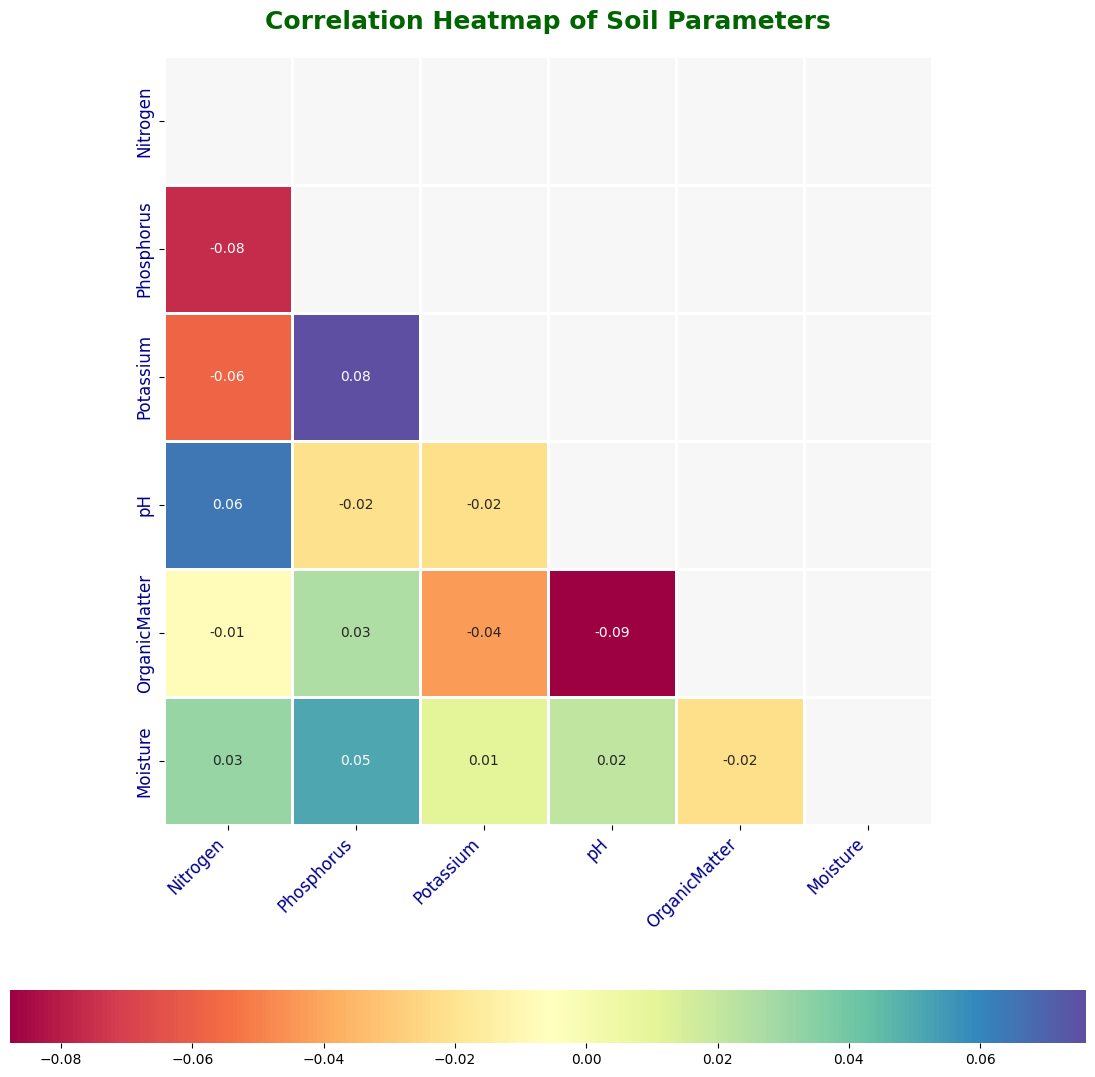

In [27]:
# Advanced Correlation Heatmap
plt.figure(figsize=(14, 12))  # Larger figure for better readability

# Compute the correlation matrix
correlation = soil_data.drop('FertilityClass', axis=1).corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation))

# Plot the heatmap
sns.heatmap(
    correlation, 
    annot=True,        # Display correlation values
    mask=mask,         # Mask upper triangle
    cmap='Spectral',   # Modern colormap for enhanced differentiation
    fmt=".2f",         # Format correlation values to 2 decimal places
    linewidths=1,      # Define clearer gridlines
    linecolor='white', # Ensure gridlines are clearly visible
    square=True,       # Keep cells as perfect squares
    cbar_kws={'shrink': 0.8, 'orientation': 'horizontal'}  # Modernize colorbar
)

# Enhance the title and layout
plt.title(
    "Correlation Heatmap of Soil Parameters",
    fontsize=18, fontweight='bold', color='darkgreen', pad=20
)
plt.xticks(fontsize=12, rotation=45, ha='right', color='darkblue')  # Rotated for readability
plt.yticks(fontsize=12, color='darkblue')

# Highlight main layout improvements
plt.tight_layout(pad=2)
plt.gca().set_facecolor('#f7f7f7')  # Light background for clarity

plt.show()